# Importing Libraries

In [1]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
from skimage import feature
from scipy.fftpack import dct
from sklearn.decomposition import PCA
from tensorflow.keras.preprocessing import image
from scipy.spatial import distance
import time

# Loading Training / Testing Datasets

In [2]:
# Function to read image paths from a text file
def read_image_paths(file_path):
    with open(file_path, 'r') as file:
        paths = file.read().splitlines()
    return paths


In [3]:
# Function to load images given a list of paths
def load_images(image_paths):
    images = []
    for path in image_paths:
        # 'images' is the folder containing your image files
        image_path = os.path.join(r'C:\Users\M\Downloads\dtd-r1.0.1\dtd\images', path)
        
        # Using OpenCV to read the image
        img = cv2.imread(image_path)
        images.append(img)  # Append the actual image, not the image path
    
    return images


In [4]:
train_file_path = r"C:\Users\M\Downloads\dtd-r1.0.1\dtd\labels\train1.txt"
train_image_paths = read_image_paths(train_file_path)
train_images = load_images(train_image_paths)

In [5]:
test_file_path = r"C:\Users\M\Downloads\dtd-r1.0.1\dtd\labels\test1.txt"
test_image_paths = read_image_paths(test_file_path)
test_images = load_images(test_image_paths)

# Traditional Feature Extraction

In [6]:
# Function to extract color histograms from a set of images
def extract_color_histograms(images):
    if not isinstance(images, list):
        images = [images]  # Convert single image to a list
    histograms = []
    for image in images:
        hist = cv2.calcHist([image], [0, 1, 2], None, [8, 8, 8], [0, 256, 0, 256, 0, 256])
        hist = cv2.normalize(hist, hist).flatten()
        histograms.append(hist)
    return np.array(histograms)

In [7]:
from skimage import feature

# Function to extract Local Binary Patterns (LBP) from a set of images
def extract_lbps(images):
    lbps = []
    for image in images:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        lbp = feature.local_binary_pattern(gray, P=8, R=1, method='uniform')
        hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, 59), range=[0, 58])
        hist = hist.astype("float")
        hist /= (hist.sum() + 1e-7)
        lbps.append(hist)
    return np.array(lbps)


In [8]:
class DCTImageDescriptor:
    def __init__(self, num_coefficients=16):
        self.num_coefficients = num_coefficients

    def extract_low_frequency_dct_features(self, image):
        # Apply DCT to the entire image
        dct_image = dct(dct(image, axis=0, norm='ortho'), axis=1, norm='ortho')

        # Extract low-frequency DCT coefficients from the top-left 
        low_frequency_dct = dct_image[:self.num_coefficients, :self.num_coefficients]

        # Flatten the coefficients 
        feature_vector = low_frequency_dct.flatten()

        return feature_vector

    def normalize_feature_vector(self, feature_vector):
        # Apply Z-score normalization 
        mean = np.mean(feature_vector)
        std = np.std(feature_vector)
        normalized_feature_vector = (feature_vector - mean) / std

        return normalized_feature_vector

    def create_descriptor(self, image):
        # Extract low-frequency DCT features
        feature_vector = self.extract_low_frequency_dct_features(image)

        # Normalize the feature vector
        normalized_feature_vector = self.normalize_feature_vector(feature_vector)

        return normalized_feature_vector




In [9]:
# Extract DCT features for all images in the training set
dct_descriptor = DCTImageDescriptor(num_coefficients=16)
train_dct_features = np.array([dct_descriptor.create_descriptor(image) for image in train_images])


In [10]:
# Extract features for all images in the training set
train_color_histograms = extract_color_histograms(train_images)


In [11]:
train_lbps = extract_lbps(train_images)

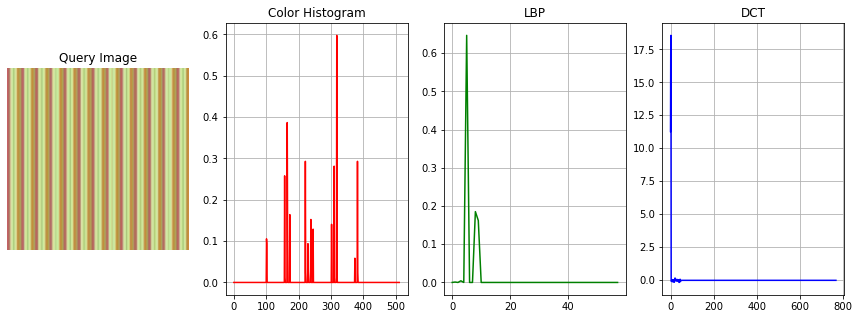

In [12]:
# Select a query image index from the test set
query_image_index = 0
query_image = test_images[query_image_index]

# Extract features for the query image using Color Histogram
query_color_histogram = extract_color_histograms([query_image])[0]

# Extract features for the query image using Local Binary Patterns (LBP)
query_lbp = extract_lbps([query_image])[0]

# Extract features for the query image using DCT
query_dct = dct_descriptor.create_descriptor(query_image)

# Display the query image and its extracted features
plt.figure(figsize=(15, 5))

# Display the query image
plt.subplot(1, 4, 1)
plt.imshow(cv2.cvtColor(query_image, cv2.COLOR_BGR2RGB))
plt.title('Query Image')
plt.axis('off')

# Display Color Histogram features
plt.subplot(1, 4, 2)
plt.plot(query_color_histogram, color='red')
plt.title('Color Histogram')
plt.grid()

# Display LBP features
plt.subplot(1, 4, 3)
plt.plot(query_lbp, color='green')
plt.title('LBP')
plt.grid()

# Display DCT features
plt.subplot(1, 4, 4)
plt.plot(query_dct, color='blue')
plt.title('DCT')
plt.grid()

plt.show()


# Deep Feature Extraction : VGG16 Model

1/1 [==============================] - 0s 195ms/step


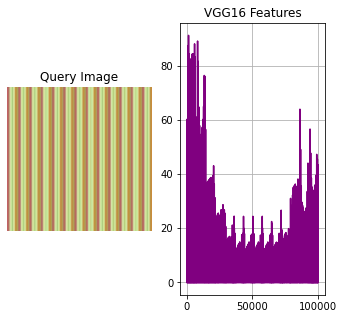

In [13]:
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import Model

# Load VGG16 model pre-trained on ImageNet data
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Function to preprocess images for VGG16
def preprocess_images_vgg16(images):
    processed_images = [preprocess_input(cv2.resize(image, (224, 224))) for image in images]
    return np.array(processed_images)

# Function to extract features using VGG16
def extract_features_vgg16(images):
    # Preprocess the images for VGG16
    processed_images = preprocess_images_vgg16(images)

    # Extract features from the last convolutional layer of VGG16
    feature_extractor = Model(inputs=base_model.input, outputs=base_model.get_layer('block5_conv3').output)
    features = feature_extractor.predict(processed_images, verbose=1)

    return features

# Extract VGG16 features for all images in the training set
train_vgg16_features = extract_features_vgg16(train_images)

# Extract VGG16 features for the query image
query_vgg16_features = extract_features_vgg16([query_image])

# Display the query image and its extracted VGG16 features
plt.figure(figsize=(15, 5))

# Display the query image
plt.subplot(1, 5, 1)
plt.imshow(cv2.cvtColor(query_image, cv2.COLOR_BGR2RGB))
plt.title('Query Image')
plt.axis('off')

# Display VGG16 features
plt.subplot(1, 5, 2)
plt.plot(query_vgg16_features.flatten(), color='purple')
plt.title('VGG16 Features')
plt.grid()

plt.show()


In [14]:
# Combine traditional features with VGG16 features for the training set
train_combined_features = np.concatenate((train_color_histograms, train_lbps, train_dct_features.reshape(train_dct_features.shape[0], -1), train_vgg16_features.reshape(train_vgg16_features.shape[0], -1)), axis=1)


In [15]:
 # Combine traditional features with VGG16 features for the query image
query_combined_features = np.concatenate((query_color_histogram, query_lbp, query_dct, query_vgg16_features.flatten()), axis=None)

# Dimensionality Reduction:

In [21]:
def apply_pca(features, num_components):
    pca = PCA(n_components=num_components)
    pca_features = pca.fit_transform(features)
    return pca, pca_features


In [37]:
 num_components = 50  # You can adjust this value based on your requirements

# Apply PCA to color histograms
pca_color_histograms, train_pca_color_histograms = apply_pca(train_color_histograms, num_components)
query_pca_color_histogram = pca_color_histograms.transform([query_color_histogram])

# Apply PCA to LBPs
pca_lbps, train_pca_lbps = apply_pca(train_lbps, num_components)
query_pca_lbp = pca_lbps.transform([query_lbp])

# Apply PCA to DCT features
pca_dct, train_pca_dct = apply_pca(train_dct_features, num_components)
query_pca_dct = pca_dct.transform([query_dct])

# Combine the PCA-transformed traditional features with VGG16 features for the training set
train_combined_pca_features = np.concatenate((
    train_pca_color_histograms,
    train_pca_lbps,
    train_pca_dct,
    train_vgg16_features.reshape(train_vgg16_features.shape[0], -1)
), axis=1)

# Combine the PCA-transformed traditional features with VGG16 features for the query image
query_combined_pca_features = np.concatenate((
    query_pca_color_histogram.flatten(),
    query_pca_lbp.flatten(),
    query_pca_dct.flatten(),
    query_vgg16_features.flatten()
), axis=None)


In [24]:
def distance(vector1, vector2):
    """Computes the cosine distance between two image features."""
    return 1.0 - np.dot(vector1, vector2) / (np.linalg.norm(vector1) * np.linalg.norm(vector2))

In [25]:
# Measure the retrieval time
start = time.time()

# Calculate distances between the query and all training images based on color histograms
distances_color = [distance(query_pca_color_histogram[0], train_pca_color_histograms[i]) for i in range(len(train_pca_color_histograms))]
idx_closest_10_color = sorted(range(len(distances_color)), key=lambda k: distances_color[k])[:10]

# Display retrieval time
print('Retrieval time:', time.time() - start)
print('=================================================================================================================')

# Retrieve and display the paths of the top 10 closest images
closest_images_10_color = [train_image_paths[i] for i in idx_closest_10_color]
print('\n'.join(closest_images_10_color))
print('=================================================================================================================')

# Retrieve and display the path of the closest image
closest_images_1_color = [train_image_paths[i] for i in idx_closest_10_color[:1]]
print('\n'.join(closest_images_1_color))


Retrieval time: 0.02425551414489746
blotchy/blotchy_0009.jpg
pitted/pitted_0040.jpg
grooved/grooved_0158.jpg
fibrous/fibrous_0204.jpg
fibrous/fibrous_0176.jpg
scaly/scaly_0162.jpg
zigzagged/zigzagged_0052.jpg
crosshatched/crosshatched_0094.jpg
cracked/cracked_0113.jpg
stained/stained_0100.jpg
blotchy/blotchy_0009.jpg


In [26]:
# Measure the retrieval time for LBPs
start = time.time()

# Calculate distances between the query and all training images based on LBPs
distances_lbp = [distance(query_pca_lbp[0], train_pca_lbps[i]) for i in range(len(train_pca_lbps))]
idx_closest_10_lbp = sorted(range(len(distances_lbp)), key=lambda k: distances_lbp[k])[:10]

# Display retrieval time
print('Retrieval time:', time.time() - start)
print('=================================================================================================================')

# Retrieve and display the paths of the top 10 closest images for LBPs
closest_images_10_lbp = [train_image_paths[i] for i in idx_closest_10_lbp]
print('\n'.join(closest_images_10_lbp))
print('=================================================================================================================')

# Retrieve and display the path of the closest image for LBPs
closest_images_1_lbp = [train_image_paths[i] for i in idx_closest_10_lbp[:1]]
print('\n'.join(closest_images_1_lbp))


Retrieval time: 0.024585247039794922
grooved/grooved_0078.jpg
banded/banded_0051.jpg
lined/lined_0038.jpg
gauzy/gauzy_0102.jpg
grooved/grooved_0057.jpg
lined/lined_0037.jpg
banded/banded_0060.jpg
pleated/pleated_0111.jpg
sprinkled/sprinkled_0030.jpg
gauzy/gauzy_0192.jpg
grooved/grooved_0078.jpg


In [27]:
# Measure the retrieval time for DCT
start = time.time()

# Calculate distances between the query and all training images based on DCT
distances_dct = [distance(query_pca_dct[0], train_pca_dct[i]) for i in range(len(train_pca_dct))]
idx_closest_10_dct = sorted(range(len(distances_dct)), key=lambda k: distances_dct[k])[:10]

# Display retrieval time
print('Retrieval time:', time.time() - start)
print('=================================================================================================================')

# Retrieve and display the paths of the top 10 closest images for DCT
closest_images_10_dct = [train_image_paths[i] for i in idx_closest_10_dct]
print('\n'.join(closest_images_10_dct))
print('=================================================================================================================')

# Retrieve and display the path of the closest image for DCT
closest_images_1_dct = [train_image_paths[i] for i in idx_closest_10_dct[:1]]
print('\n'.join(closest_images_1_dct))


Retrieval time: 0.021927833557128906
crosshatched/crosshatched_0078.jpg
dotted/dotted_0131.jpg
zigzagged/zigzagged_0071.jpg
woven/woven_0066.jpg
zigzagged/zigzagged_0052.jpg
woven/woven_0039.jpg
polka-dotted/polka-dotted_0206.jpg
dotted/dotted_0041.jpg
waffled/waffled_0090.jpg
wrinkled/wrinkled_0068.jpg
crosshatched/crosshatched_0078.jpg


In [28]:
# Measure the retrieval time for Deep features
start = time.time()

# Flatten the query VGG16 features
query_flat_vgg16 = query_vgg16_features.flatten()

# Flatten the training VGG16 features
train_flat_vgg16 = [feature.flatten() for feature in train_vgg16_features]

# Calculate distances between the query and all training images based on VGG16 features
distances_deep = [distance(query_flat_vgg16, train_flat_vgg16[i]) for i in range(len(train_flat_vgg16))]
idx_closest_10_deep = sorted(range(len(distances_deep)), key=lambda k: distances_deep[k])[:10]

# Display retrieval time
print('Retrieval time (Deep Features):', time.time() - start)
print('=================================================================================================================')

# Retrieve and display the paths of the top 10 closest images for Deep features
closest_images_10_deep = [train_image_paths[i] for i in idx_closest_10_deep]
print('\n'.join(closest_images_10_deep))
print('=================================================================================================================')

# Retrieve and display the path of the closest image for Deep features
closest_images_1_deep = [train_image_paths[i] for i in idx_closest_10_deep[:1]]
print('\n'.join(closest_images_1_deep))


Retrieval time (Deep Features): 0.3893277645111084
banded/banded_0021.jpg
banded/banded_0005.jpg
lined/lined_0038.jpg
lined/lined_0037.jpg
lined/lined_0166.jpg
lined/lined_0067.jpg
banded/banded_0019.jpg
banded/banded_0033.jpg
banded/banded_0011.jpg
banded/banded_0013.jpg
banded/banded_0021.jpg


In [29]:
# Measure the retrieval time for the combined features
start = time.time()

# Calculate distances between the query and all training images based on combined features
distances_combined = [distance(query_combined_pca_features, train_combined_pca_features[i]) for i in range(len(train_combined_pca_features))]
idx_closest_10_combined = sorted(range(len(distances_combined)), key=lambda k: distances_combined[k])[:10]

# Display retrieval time
print('Retrieval time (Combined Features):', time.time() - start)
print('=================================================================================================================')

# Retrieve and display the paths of the top 10 closest images for combined features
closest_images_10_combined = [train_image_paths[i] for i in idx_closest_10_combined]
print('\n'.join(closest_images_10_combined))
print('=================================================================================================================')

# Retrieve and display the path of the closest image for combined features
closest_images_1_combined = [train_image_paths[i] for i in idx_closest_10_combined[:1]]
print('\n'.join(closest_images_1_combined))

Retrieval time (Combined Features): 0.11548948287963867
banded/banded_0021.jpg
banded/banded_0005.jpg
lined/lined_0038.jpg
lined/lined_0037.jpg
lined/lined_0166.jpg
lined/lined_0067.jpg
banded/banded_0019.jpg
banded/banded_0033.jpg
banded/banded_0011.jpg
banded/banded_0013.jpg
banded/banded_0021.jpg


# Evaluation metrics:

In [30]:
def calculate_precision_recall(distances, query_path):
    sorted_images_indices = sorted(range(len(distances)), key=lambda k: distances[k])
    
    # the label of the query image is already in its own path
    query_class = os.path.basename(os.path.dirname(query_path))
    
    # gather all the images of the same label as the query's in the training sorted images 
    num_all_relevant_train = sum(
        1 for i in sorted_images_indices if query_class == os.path.basename(os.path.dirname(train_image_paths[i]))
    )
    
    precisions = []
    recalls = []
    
    if num_all_relevant_train == 0:
        return [], []  # Return empty lists if there are no relevant training images (of the same class)
    
    num_predicted_well = 0
    for i, retrieved_image_index in enumerate(sorted_images_indices):
        num_retrieved = i + 1
        if query_class == os.path.basename(os.path.dirname(train_image_paths[retrieved_image_index])):
            num_predicted_well += 1
        precisions.append(num_predicted_well / num_retrieved)
        recalls.append(num_predicted_well / num_all_relevant_train)
    
    return precisions, recalls


In [31]:
import matplotlib.pyplot as plt

def plot_precision_recall_curve(precisions, recalls):
    """
    Plot the precision-recall curve.
    """
    plt.plot(recalls, precisions)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.show()


[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


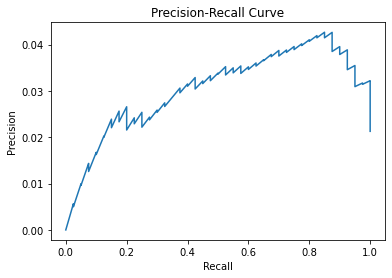

In [32]:
# Assuming test_image_paths is a list containing file paths of test images
query_image_path_color = test_image_paths[0]

# Calculate precision-recall for PCA + Color Histogram feature
precisions_pca_color, recalls_pca_color = calculate_precision_recall(distances_color, query_image_path_color)

# Print and plot the results
print(precisions_pca_color[:11])
print(recalls_pca_color[:11])

# Plot the precision-recall curve
plot_precision_recall_curve(precisions_pca_color, recalls_pca_color)


[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


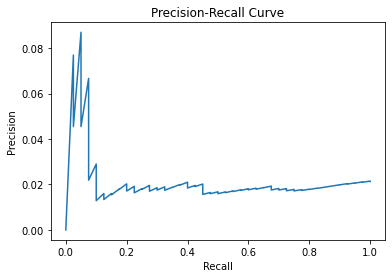

In [33]:

# Assuming test_image_paths is a list containing file paths of test images
query_image_path_dct = test_image_paths[0]

# Calculate precision-recall for PCA + DCT feature
precisions_pca_dct, recalls_pca_dct = calculate_precision_recall(distances_dct, query_image_path_dct)

# Print and plot the results
print(precisions_pca_dct[:11])
print(recalls_pca_dct[:11])

# Plot the precision-recall curve
plot_precision_recall_curve(precisions_pca_dct, recalls_pca_dct)



[0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16666666666666666, 0.2857142857142857, 0.25, 0.2222222222222222, 0.2, 0.18181818181818182]
[0.0, 0.025, 0.025, 0.025, 0.025, 0.025, 0.05, 0.05, 0.05, 0.05, 0.05]


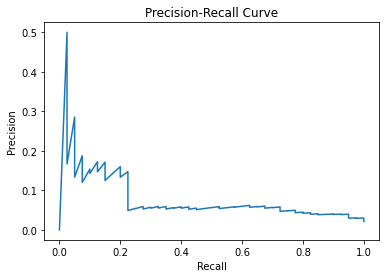

In [35]:
# Assuming test_image_paths is a list containing file paths of test images
query_image_path_lbp = test_image_paths[0]

# Calculate precision-recall for LBP feature
precisions_lbp, recalls_lbp = calculate_precision_recall(distances_lbp, query_image_path_lbp)

# Print and plot the results
print(precisions_lbp[:11])
print(recalls_lbp[:11])

# Plot the precision-recall curve
plot_precision_recall_curve(precisions_lbp, recalls_lbp)


[1.0, 1.0, 0.6666666666666666, 0.5, 0.4, 0.3333333333333333, 0.42857142857142855, 0.5, 0.5555555555555556, 0.6, 0.5454545454545454]
[0.025, 0.05, 0.05, 0.05, 0.05, 0.05, 0.075, 0.1, 0.125, 0.15, 0.15]


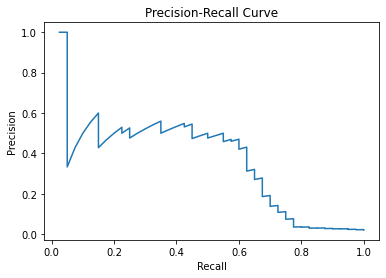

In [36]:
# Calculate precision-recall for deep features
precisions_pca_deep, recalls_pca_deep = calculate_precision_recall(distances_deep, test_image_paths[0])

# Print and plot the results
print(precisions_pca_deep[:11])
print(recalls_pca_deep[:11])

# Plot the precision-recall curve
plot_precision_recall_curve(precisions_pca_deep, recalls_pca_deep)

[1.0, 1.0, 0.6666666666666666, 0.5, 0.4, 0.3333333333333333, 0.42857142857142855, 0.5, 0.5555555555555556, 0.6, 0.5454545454545454]
[0.025, 0.05, 0.05, 0.05, 0.05, 0.05, 0.075, 0.1, 0.125, 0.15, 0.15]


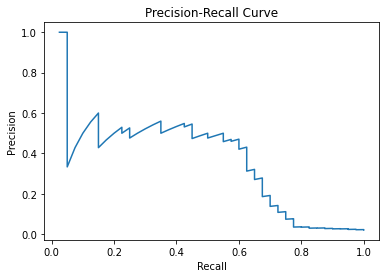

In [39]:
precisions_pca_combined, recalls_pca_combined = calculate_precision_recall(distances_combined,  test_image_paths[0])

print(precisions_pca_combined[:11])
print(recalls_pca_combined[:11])

plot_precision_recall_curve(precisions_pca_combined, recalls_pca_combined)